# Preparing your log file
You should be able to use your saved logfile, however if you have colorized log output from trunk-recorder, you'll need to use asci2txt from `colorized-logs` to strip those codes out.

* docker logs trunk-recorder 2> tr.log
* ansi2txt < tr.log > tr.log.log
* gzip tr.log

In [1]:
import datetime
import gzip
import re
import pandas as pd

logfile = gzip.open("tr.log.gz", "rt")
calldict = {}
# Define the regex pattern for our log entries
# line = "[2024-05-09 12:31:45.009426] (info)   [pwcp25]	126C	TG:       1007 (            PWPD West 1)	Freq: 851.962500 MHz	Concluding Recorded Call - Last Update: 4s	Recorder last write:4.72949	Call Elapsed: 12"
# log_pattern = r".*\[(\S+\s\S+)\]\s+\((\S+)\)\s+\[(\S+)\]\s+(\d+).*TG:.*\((.*)\).*Freq:\s+(\d+\.\d+).*MHz\s+(.*)"
log_pattern = r".*\[(\S+\s\S+)\]\s+\((\S+)\)\s+\[(\S+)\]\s+(\d+)\S+\s+\S+\s+(\d+).*Freq:\s+(\d+\.\d+).*MHz\s+(.*)"
# If you DO NOT have "talkgroupDisplayFormat": "id_tag" set, you can change the log_pattern to this below to grab the numeric
# talkgroup numbers:
# log_pattern = r".*\[(\S+\s\S+)\]\s+\((\S+)\)\s+\[(\S+)\]\s+(\d+)\S+\s+\S+\s+(\d+).*Freq:\s+(\d+\.\d+).*MHz\s+(.*)"
for line in logfile:
    # line = "2024-05-09T12:23:26.007469771Z [2024-05-09 12:23:26.005761] (info)   [pwcp25]	16C	TG:       2003 (                PWFD 5B)	Freq: 851.725000 MHz	Concluding Recorded Call - Last Update: 4s	Recorder last write:4.79871	Call Elapsed: 13"
    if match := re.match(log_pattern, line):
        calldata = match[7]
        # Technically this isn't a real unixtimestamp as it's not timezone aware,
        # but we're just using it to create a unique index identifier.
        calldate = datetime.datetime.strptime(match[1], "%Y-%m-%d %H:%M:%S.%f")
        callts = calldate.timestamp()
        # Index for the dict is timestamp(ish)-talkgroup
        callindex = f"{int(callts)}{int(match[5].strip())}"

        # Second round of regexp.  Now we are going to harvest data from calldata - the "everything else"
        regexp_dict = {
            "excluded": r".*(Not recording talkgroup.).*",
            "encrypted": r".*(Not Recording: ENCRYPTED).*",
            "unknown_tg": r".*(TG not in Talkgroup File).*",
            "no_source": r".*(no source covering Freq).*",
            "standard": r".*Call Elapsed:\s+(\d+)",
        }
        for callclass, data_pattern in regexp_dict.items():
            if datamatch := re.match(data_pattern, calldata):
                calldict[callindex] = {"callclass": callclass}
                if callclass == "standard":
                    calldict[callindex] = {"duration": int(datamatch[1])}
                    # This log event happens at the end of a call, so we should adjust the calltime
                    # back by duration seconds to get to the start.
                    calldate = calldate + datetime.timedelta(seconds=-int(datamatch[1]))
                calldict[callindex].update(
                    {
                        "calldate": str(calldate),
                        "loglevel": str(match[2]),
                        "system": str(match[3]),
                        "callnumber": int(match[4]),
                        "talkgroup": int(match[5].strip()),
                        "frequency": float(match[6]),
                    }
                )
logfile.close()

calldf = pd.DataFrame.from_dict(calldict, orient="index")
# Technically this shouldn't be needed.  The dict construction _should_ set the class
# but for some reason it skips setting standard.  It does set duration though so that part of
# of the loop works.  This workaround sets the class to standard if there is a duration.
calldf.loc[calldf["duration"].notna(), "callclass"] = "standard"

# We're going to use ChanList.csv if we have it to convert decimal talkgroups to their
# Alpha Longform.  While this could be in the original log line, we do it here to take care
# of logs which might not have that enabled AND it allows us to see the number value of "unlisted" tg.
try:
    chanlist = pd.read_csv("ChanList.csv")
    calldf = pd.merge(
        left=calldf,
        right=chanlist,
        left_on="talkgroup",
        right_on="Decimal",
        how="left",
    )
    # Talkgroup was an int for matching; now it becomes a string
    calldf[["talkgroup"]] = calldf[["talkgroup"]].astype("str")
    # And now we merge in the Alpha Tag to talkgroups defined.  Undefined keep their
    # numeric value
    calldf.loc[calldf["Alpha Tag"].notna(), "talkgroup"] = calldf["Alpha Tag"]
except Exception:
    print("We couldn't open ChanList so talkgroups will remain numeric.")
# Finally, either way let's sort the columns in the dataframe and dump the extra columns
# from the ChanList merge
calldf = calldf.filter(
    [
        "calldate",
        "loglevel",
        "system",
        "callnumber",
        "callclass",
        "talkgroup",
        "frequency",
        "duration",
    ],
    axis=1,
)
calldf.sort_values(by="calldate", inplace=True)

In [2]:
import matplotlib.pyplot as plt
#%matplotlib widget
import numpy as np

# pd.set_option("display.max_rows", 999)
# pd.set_option("display.precision", 5)
display(calldf.head().style.hide(axis="index"))

calldate,loglevel,system,callnumber,callclass,talkgroup,frequency,duration
2024-05-09 12:22:31.005216,info,pwcp25,1,standard,PWFD 5B,851.962500,7.000000
2024-05-09 12:22:31.009743,info,pwcp25,2,standard,PWPD Central 1,852.900000,25.000000
2024-05-09 12:22:31.574226,error,pwcp25,0,no_source,PWPD Central 1,0.000000,nan
2024-05-09 12:22:33.317803,info,pwcp25,3,excluded,PWSchBus W,852.725000,nan
2024-05-09 12:22:35.007133,info,pwcp25,4,standard,PWFD 5B,852.787500,14.000000


In [3]:
call_duration_count = calldf["duration"].notnull().sum()
average_call_duration = calldf["duration"].mean()
average_call_duration = np.round(average_call_duration, 2)
display(f"The Average Call Duration is: {average_call_duration} seconds")

'The Average Call Duration is: 13.21 seconds'

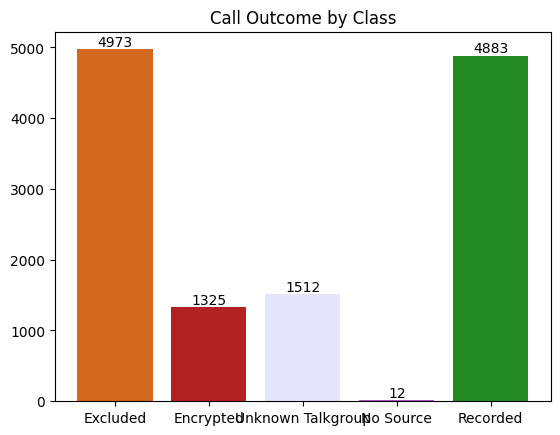

In [4]:
total_call_count = calldf.shape[0]

excludeddf = calldf[calldf["callclass"] == "excluded"]
excluded_call_count = excludeddf["callclass"].shape[0]

encrypteddf = calldf[calldf["callclass"] == "encrypted"]
encrypted_call_count = encrypteddf["callclass"].shape[0]

unknowndf = calldf[calldf["callclass"] == "unknown_tg"]
unknown_talkgroup_count = unknowndf["callclass"].shape[0]

nosourcedf = calldf[calldf["callclass"] == "no_source"]
no_source_count = nosourcedf["callclass"].shape[0]

standarddf = calldf[calldf["callclass"] == "standard"]
standard_count = standarddf["callclass"].shape[0]



# display(f"The Total Number of Calls is: {total_call_count}")
# display("Of those:")
# display(
#     f"{excluded_call_count} were excluded, likely due to the talkgroup being excluded"
# )
# display(f"{encrypted_call_count} were encrypted and not recorded")
# display(
#     f"{unknown_talkgroup_count} were in an unknown talkgroup and were recorded or not based on your settings"
# )
# display(f"{no_source_count } had no source covering the frequency")
# doublecheck = (
#     excluded_call_count
#     + encrypted_call_count
#     + unknown_talkgroup_count
#     + no_source_count
#     + standard_count
# )
# display(f"Temporary double-check: {doublecheck} should match {calldf.shape[0]}")

# Graph time!
callcounts = [
    excluded_call_count,
    encrypted_call_count,
    unknown_talkgroup_count,
    no_source_count,
    standard_count,
]
callcategories = ("Excluded", "Encrypted", "Unknown Talkgroup", "No Source", "Recorded")

y_pos = np.arange(len(callcategories))
bar_colors = ["chocolate", "firebrick", "lavender", "mediumorchid", "forestgreen"]
# Create bars
p = plt.bar(y_pos, callcounts, color=bar_colors)
plt.bar_label(p)  # This puts the number on the top of each bar
plt.title("Call Outcome by Class")
# Create names on the x-axis
plt.xticks(y_pos, callcategories)
# Show graphic
plt.show()

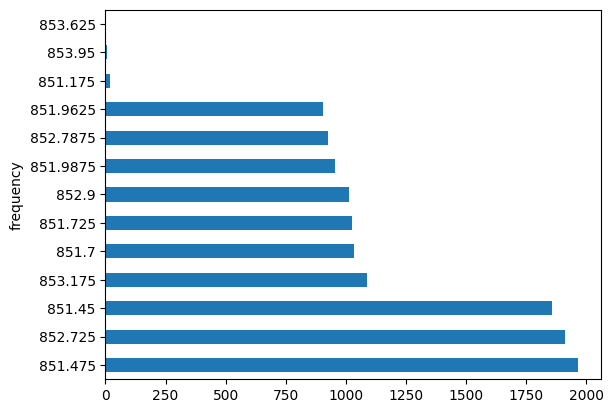

In [5]:
# Filter out the 0 frequency listings common when trunk-recorder first starts up.
frequencydf = calldf[calldf["frequency"] != 0]
freq_used = frequencydf["frequency"].value_counts()

freq_used.plot.barh()
plt.show()

In [6]:
nosourcedf = calldf[calldf["callclass"] == "no_source"]
nosourcedf["frequency"].unique()

array([  0.   , 851.175])

In [7]:
#timeseriesdf = calldf.set_index("calldate")
